# CONVOLUTION  AUTOENCODERS

In [198]:
import tensorflow as tf
from tensorflow.keras.models import save_model
import tensorflow.keras.layers as L
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [199]:
#loading images
path='C:\\Users\\Prasanna Ganapathi S\\lungimage\\train'

In [200]:
from keras.preprocessing.image import ImageDataGenerator

In [201]:
train_batches=ImageDataGenerator().flow_from_directory(path,target_size=(224,224),classes=['malignant','benign'],batch_size=70)
imgs,labels=next(train_batches)

Found 20 images belonging to 2 classes.


In [202]:
IMG_SHAPE=imgs.shape[1:]

In [203]:
imgs = imgs.astype('float32') / 255.0 - 0.5

In [204]:
print("img.max:",imgs.max())
print("img.min:",imgs.min())

img.max: 0.5
img.min: -0.5


In [205]:
x_train,x_test=train_test_split(imgs,test_size=0.2, random_state=42)

In [206]:
len(x_train)

16

In [207]:
len(x_test)

4

In [208]:
x_train.shape

(16, 224, 224, 3)

In [209]:
x_test.shape

(4, 224, 224, 3)

In [210]:
IMG_SHAPE

(224, 224, 3)

In [211]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

images shape: (20, 224, 224, 3)
attr shape: (20, 2)


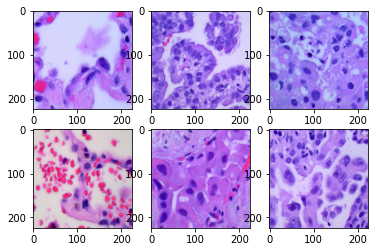

In [212]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(imgs[i])

print("images shape:", imgs.shape)
print("attr shape:", labels.shape)

In [213]:
def build_deep_autoencoder(img_shape, code_size):
    
    H,W,C = img_shape
    
    # encoder
    encoder = tf.keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    ### YOUR CODE HERE: define encoder as per instructions above ###
    encoder.add(L.Conv2D(filters=32,input_shape=(224,224,3), kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))

    # decoder
    decoder = tf.keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    ### YOUR CODE HERE: define decoder as per instructions above ###
    decoder.add(L.Dense(14*14*256,))
    decoder.add(L.Reshape((14,14, 256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder


In [214]:
# Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    tf.keras.backend.clear_session()
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    print("encoder",encoder.output_shape[1:])
    print("decoder",decoder.output_shape[1:])
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")

Testing code size 1
encoder (1,)
decoder (224, 224, 3)
Testing code size 8
encoder (8,)
decoder (224, 224, 3)
Testing code size 32
encoder (32,)
decoder (224, 224, 3)
Testing code size 128
encoder (128,)
decoder (224, 224, 3)
Testing code size 512
encoder (512,)
decoder (224, 224, 3)
All tests passed!


In [215]:
tf.keras.backend.clear_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=20)
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2

In [216]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

In [217]:
code

<tf.Tensor 'sequential/dense/BiasAdd:0' shape=(None, 20) dtype=float32>

In [218]:
inp

<tf.Tensor 'input_3:0' shape=(None, 224, 224, 3) dtype=float32>

In [219]:
reconstruction

<tf.Tensor 'sequential_1/conv2d_transpose_3/BiasAdd:0' shape=(None, 224, 224, 3) dtype=float32>

In [220]:
autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse',metrics=['accuracy'])

In [221]:
autoencoder.fit(x=x_train, y=x_train, epochs=40,
                validation_data=[x_test, x_test])

Epoch 1/40
1/1 [==============================] - 0s 164ms/step - loss: 0.0834 - accuracy: 0.3312 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/40
1/1 [==============================] - 0s 20ms/step - loss: 0.0823 - accuracy: 0.3937 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/40
1/1 [==============================] - 0s 18ms/step - loss: 0.0801 - accuracy: 0.3848 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/40
1/1 [==============================] - 0s 18ms/step - loss: 0.0734 - accuracy: 0.3723 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/40
1/1 [==============================] - 0s 16ms/step - loss: 0.0617 - accuracy: 0.3710 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/40
1/1 [==============================] - 0s 17ms/step - loss: 0.0844 - accuracy: 0.3856 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/40
1/1 [==============================] - 0s 15ms/step - loss: 0.0554 - accuracy: 0.4106 - val_loss: 0.0000e+

In [222]:
predictions=autoencoder.predict(x_test)

In [223]:
predictions.shape

(4, 224, 224, 3)

In [224]:
results = autoencoder.evaluate(x_train,x_train)
print('loss, accuracy', results)

1/1 [==============================] - 0s 998us/step - loss: 0.0254 - accuracy: 0.7053
loss, accuracy [0.025378553196787834, 0.7053496837615967]


In [225]:
results1 = autoencoder.evaluate(x_test,x_test)
print('loss, accuracy', results1)

1/1 [==============================] - 0s 1ms/step - loss: 0.0286 - accuracy: 0.6353
loss, accuracy [0.028551440685987473, 0.635273814201355]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


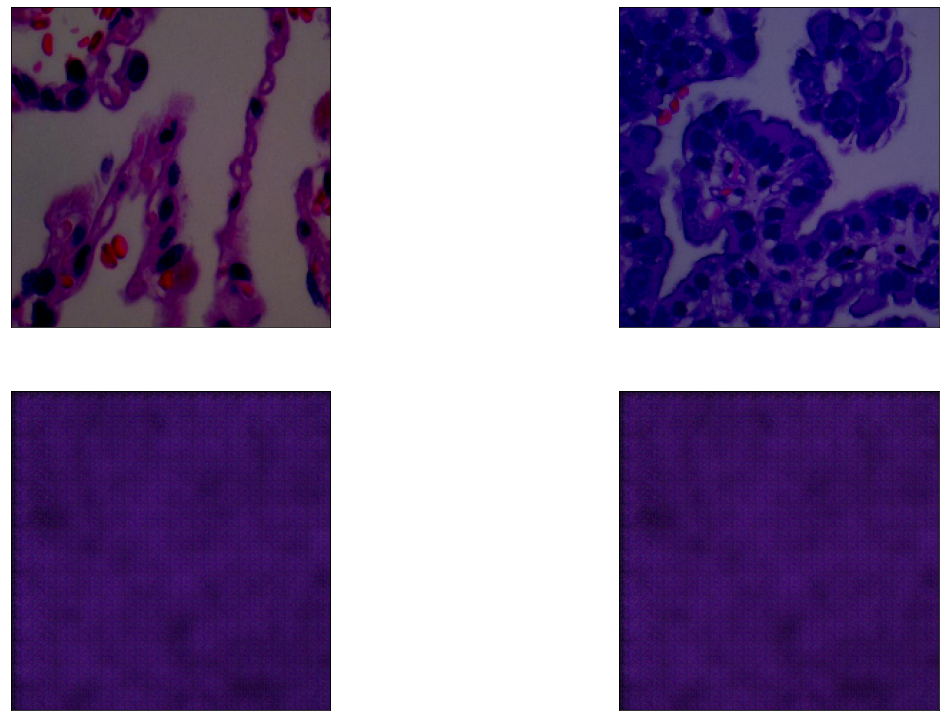

In [227]:
n = 2
plt.figure(figsize= (20,20))

for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(x_test[i+2])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions[i+2])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


plt.show()

# saving model
model_filename='autoencoder.{0:03d}.hdf5'
last_finished_epoch=None

autoencoder.fit(x=x_train, y=x_train, epochs=15,
                validation_data=[x_test, x_test],
                callbacks=[ModelSaveCallback(model_filename)],
                           #keras_utils.TqdmProgressCallback()],
                verbose=1,
                initial_epoch=last_finished_epoch or 0)

In [194]:
class ModelSaveCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [195]:
def visualize(img,encoder,decoder):
    
    code = encoder.predict(img[None])[0] 
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

Convolutional autoencoder MSE: [0.025418264791369438, 0.5977402329444885]


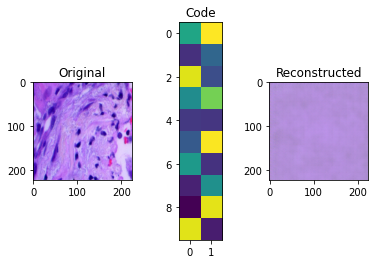

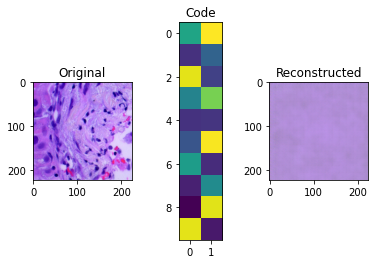

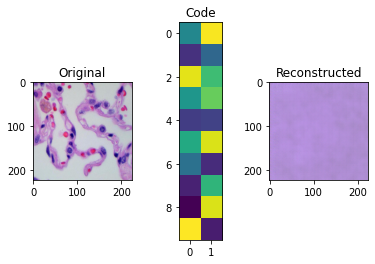

In [196]:
reconstruction_mse = autoencoder.evaluate(x_test, x_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(3):
    img = x_test[i]
    visualize(img,encoder,decoder)

In [197]:
results = autoencoder.evaluate(x_test,x_test)
print('loss, accuracy', results)

1/1 [==============================] - 0s 998us/step - loss: 0.0254 - accuracy: 0.5977
loss, accuracy [0.025418264791369438, 0.5977402329444885]
